# Lab 4 (Part A): Regularized Linear Regression

In this Lab, you will implement regularized linear regression and use it to study models with different bias-variance properties. Make sure that you check the videos of lecture 5 before starting this Lab:
- Overfitting, Generalization, and Regularization: https://youtu.be/-zVe8upJMDU

In this part of the Lab, you will first implement regularized linear regression to predict the amount of water owing out of a dam using the change of water level in a reservoir. Then, you will examine the effects of bias vs. variance.

## Loading the data
We have a file `water-level-dataset.mat` which contains the dataset for our linear regression problem. The `.mat` file can be loaded in Python using `scipy.io.loadmat(..)` which returns a dictionary that contains 6 arrays. The follwing Python code load these arrays into the variables: `X`, `y`, `Xtest`, `ytest`, `Xval`, `yval`. So, our data is divided into three parts:
- A training set that your model will learn on: `X`, `y`
- A cross validation set for determining the regularization parameter: `Xval`, `yval`
- A test set for evaluating performance. These are *unseen* examples which your model did not see during training: `Xtest`, `ytest`.

Read the following code and print a small subset of these arrays to see what they look like.

In [1]:
%matplotlib notebook
from scipy.io import loadmat

mat = loadmat("datasets/water-level-dataset.mat")

# X and y correspond to a training set that your model will learn on.
X = mat["X"]
y = mat["y"].reshape(len(X))

# Xval and yval correspond to a cross validation set for determining the regularization parameter.
Xval = mat["Xval"]
yval = mat["yval"].reshape(len(Xval))

# Xtest and ytest correspond to a test set for evaluating performance. These 
# are unseen examples which your model will not see during training
Xtest = mat["Xtest"]
ytest = mat["ytest"].reshape(len(Xtest))


""" TODO:
You can print here a small subset of X, y, Xtest, ytest, Xval and Xval to see what they look like.
"""
# ...
print(X[:5],'\n', y[:5],'\n', Xval[:5],'\n', yval[:5],'\n', Xtest[:5],'\n', ytest[:5])

[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]] 
 [ 2.13431051  1.17325668 34.35910918 36.83795516  2.80896507] 
 [[-16.74653578]
 [-14.57747075]
 [ 34.51575866]
 [-47.01007574]
 [ 36.97511905]] 
 [ 4.17020201  4.0672628  31.87306758 10.62365619 31.83602128] 
 [[-33.31800399]
 [-37.91216403]
 [-51.20693795]
 [ -6.13259585]
 [ 21.26118327]] 
 [ 3.31688953  5.39768952  0.13042984  6.1925982  17.08848712]


## Visualizing the data
We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water owing out of the dam, $y$. Note that the input data $X$ consists of only one feature corresponding to the "change in water level". Produce a scatter plot showing this feature vs. the output corresponding to the "water flowing out of the dam". Your plot should look like the following figure:
<img src="imgs/WaterDataScatterLab4A.png" width="400px" />


<IPython.core.display.Javascript object>


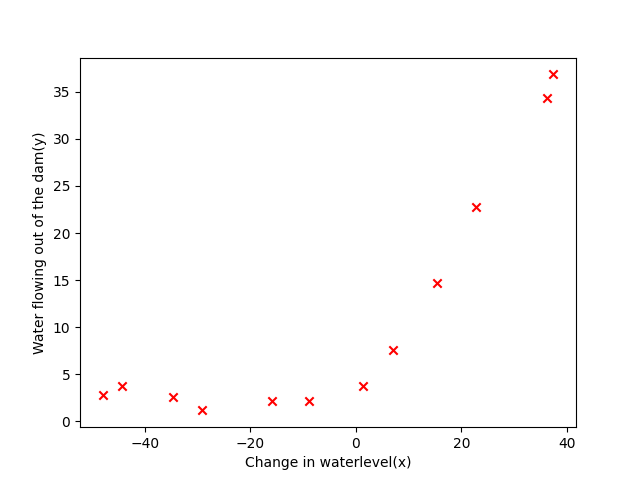

In [2]:
import matplotlib.pylab as plt

""" TODO:
Using the training dataset X and y, produce a scatter plot showing the "change in water level" on 
the x-axis and the "water flowing out of the dam" on the y-axis, as shown in the previous figure.
"""

plt.scatter(X, y, color='r', marker='x')
plt.xlabel('Change in waterlevel(x)')
plt.ylabel('Water flowing out of the dam(y)')
plt.show()

## Adding a first column of ones to the dataset
As usual, before starting the implementation of our linear regression model, it might be helpful to use a modified version of our dataset which has an additional first column of ones.

In [3]:
import numpy as np

# This function takes a matrix as argument and returns a new matrix with an additional first column (of ones)
def add_all_ones_column(X):
    n, d = X.shape # dimension of the matrix X (n lines, d columns)
    XX = np.ones((n, d+1)) # new matrix of all ones with one additional column
    XX[:, 1:] = X # set X starting from column 1 (keep only column 0 unchanged)
    return XX

# The following line creates a new data matrix X_new with an additional first column (of ones)
X_new = add_all_ones_column(X) # for the training set
Xval_new = add_all_ones_column(Xval) # for the validation set

""" TODO:
You can print a small subset of X_new here to see how it looks like 
"""
print(X_new[:5])


[[  1.         -15.93675813]
 [  1.         -29.15297922]
 [  1.          36.18954863]
 [  1.          37.49218733]
 [  1.         -48.05882945]]


## Regularized linear regression cost function
Recall that regularized linear regression has the following cost function:
$$E(\theta) = \frac{1}{2n} \left [ \left ( \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} )^2 \right ) + \lambda \left ( \sum_{j=1}^{d} \theta_j^2 \right ) \right ],$$
where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost function $E$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

Complete the following code to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are finished, call your cost function using $\theta$ initialized at `np.array([1, 1])` and $\lambda = 1$. You should then expect to see an output of about $303.993$.

In [4]:
""" TODO:
Write the definition of the regularized linear regression cost function. 
If possible, try to vectorize your code and avoid writing loops. The 
last argument lmd corresponds to the regularization term lambda.
"""
def E(theta, X, y, lmd):
    norm1 = np.linalg.norm(X@theta-y)
    norm2 = np.linalg.norm(theta)
    error = norm1*norm1+lmd*norm2*norm2
    return error/(2*len(y))


""" TODO:
Call your cost function with theta initialized to an array of ones, and 
lambda = 1. You should expect to see an output of about 303.993.
"""
theta = np.array([1, 1])
print(E(theta, X_new, y, 1))

304.0348588869309


## Regularized linear regression gradient
The partial derivative of regularized linear regression's cost for $\theta_j$ is defined as:
$$
\frac{\partial E(\theta)}{\partial \theta_0} = \frac{1}{n} \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} ) ~ x_j^{(i)}
\quad \quad \quad \quad \quad \quad \text{for } j = 0
$$

$$
\frac{\partial E(\theta)}{\partial \theta_j} = \left ( \frac{1}{n} \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} ) ~ x_j^{(i)} \right ) + \frac{\lambda}{n} \theta_j
\quad \quad \text{for } j \geq 1
$$

Complete the definition of the function `gradE(..)` in the code below, to calculate the gradient of the cost function $\nabla E(\theta)$. The function must return an array of the same length as $\theta$. When you are finished, call your gradient function using $\theta$ initialized at `np.array([1, 1])` and $\lambda = 1$. You should then expect to see a gradient of `[-15.30, 598.250]`.

In [5]:
""" TODO:
Write the definition of the gradient function. It should return an array containing 
the derivative of the cost function with respect to each parameter theta[j].
"""
def gradE(theta, X, y, lmd):
    grad = np.array([None]*len(theta))
    for j in range(len(theta)):
        if j == 0:
            grad[0] = np.sum((X@theta-y)*X.T[j])/len(y)
        else:
            grad[j] = np.sum((X@theta-y)*X.T[j])/len(y) + (lmd/len(y))*theta[j]
    return grad


""" TODO:
Call your gradient function with theta initialized to an array of ones, and 
lambda = 1. You should expect to see a gradient of approximatly [-15.30  598.250].
"""
theta = np.array([1,1])
print( gradE(theta, X_new, y, 1) )

[-15.303015674201186 598.2507441727035]


## Fitting linear regression
Once your cost function and gradient are working correctly, the following code will help you to compute the optimal values of $\theta$. We use `scipy.optimize.minimize(..)` to optimize the cost function.

In this part, we set the regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later sections of this Lab, you will be using polynomial regression with regularization.

For more information about `scipy.optimize.minimize(..)`, you can visit:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
- https://docs.scipy.org/doc/scipy/reference/optimize.html

In [6]:
import scipy.optimize as op

theta = np.array([0, 0])  # Some initial parameters vector
lmd = 0 # We set lambda to zero this time.
print("Initial cost: ", E(theta, X_new, y, lmd))


""" TODO:
Use op.minimize(..) to minimize the cost function E. Then, print the 
optimal parameter vector theta and the final cost.
"""
res = op.minimize(E, theta, (X_new, y, lmd), method='TNC', jac=gradE)
# Then, the optimal parameters can be accessed with: theta = res.x
theta = res.x
print(theta)

Initial cost:  140.95412088055394
[13.08790351  0.36777923]


## Plotting the linear regression model
One you get the optimal parameters of $\theta$, you can call the function `plot_linear_fit(X, y, theta)` defined in the code below to plot the original dataset and the best fit line. Read the code carefully to see how such a line is ploted using the $\theta$ values. You will get a plot similar to the follwing figure.

The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

<img src="imgs/RegLinePlotLab4A.png" width="400px" />

<IPython.core.display.Javascript object>


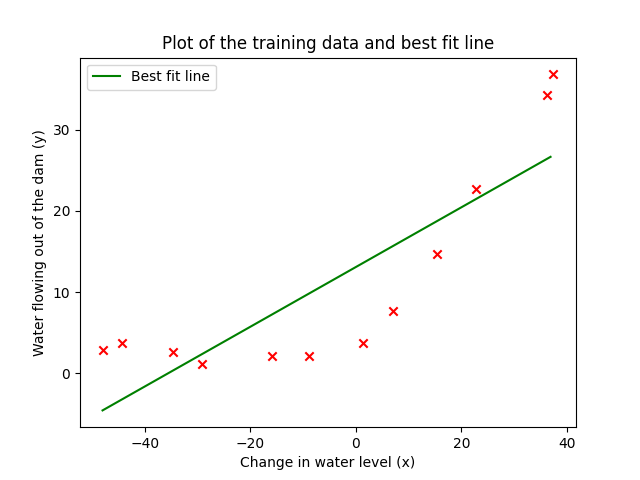

In [7]:
# This is a function that plots the original dataset (X, y) and the best fit line:
def plot_linear_fit(X, y, theta):
    fig, ax = plt.subplots()
    
    # Plottin the training data:
    ax.scatter(X[:, 0], y, marker="x", color="red")
    ax.set_xlabel("Change in water level (x)")
    ax.set_ylabel("Water flowing out of the dam (y)")
    
    # Plotting the line:
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    plot_x = np.arange(x_min, x_max) # range of values for the x axis
    plot_y = theta[0] + theta[1] * plot_x
    ax.plot(plot_x, plot_y, color="green", label="Best fit line")
    
    ax.set_title("Plot of the training data and best fit line")
    plt.legend()
    fig.show()


""" TODO:
Call the function plot_linear_fit(X, y, theta) with 
the optimal theta parameters that you got previously.
"""
plot_linear_fit(X, y, theta)

## Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. In this part of the Lab, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in the code below so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set $X$. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., `X[1:i]` and `y[1:i]`).

You can use the `scipy.optimize.minimize(..)` function to find the $\theta$ parameters. After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as:

$$E(\theta) = \frac{1}{2n} \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} )^2$$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function `E(..)` and set $\lambda$ to $0$ only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X[0:i]` and `y[0:i]`) (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors error train and error val.

When you are finished, print the learning curves and produce a plot similar to the following figure. From the figure, you can observe that both the train error and cross validation error are quite high even when the number of training examples is increased. This reflects a **high bias** problem in the model - the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

<img src="imgs/LearningCurvLab4A.png" width="400px" />

<IPython.core.display.Javascript object>


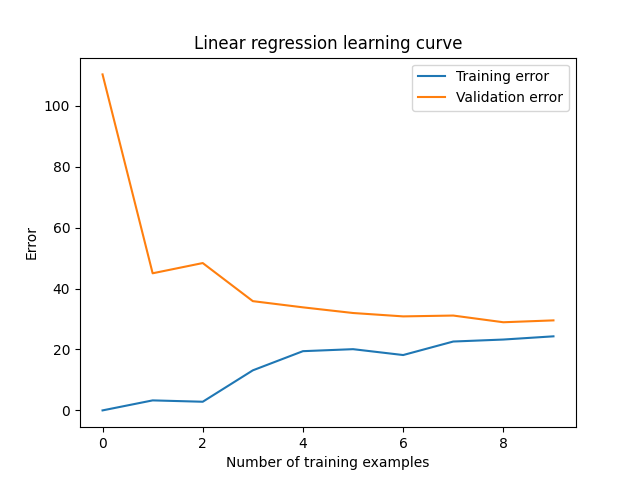

In [8]:
# This function takes some training data, an initial theta and a regularization term 
# lmd, and returns the optimal prameters vector theta of a linear regression. It uses 
# scipy.optimize.minimize(..), the cost function E(..) and the gradient gradE(..)
def trainLinearReg(X, y, theta_init, lmd):
    res = op.minimize(E, theta_init, (X, y, lmd), 'TNC', gradE)
    return res.x # the best/final parameters vector theta

""" TODO:
Inside a loop which iterates over the range of n (number of training examples), find the optimal theta by 
calling trainLinearReg(..) using the first i examples (X_new[:i], y[:i]), then compute the corresponding 
training error err_train (using X_new[:i], y[:i]) and the validation error err_val (using Xval_new, yval) ...
"""
errs_train, errs_val = [], [] # Lists to save the training and validation errors
for i in range(2, len(y)): # Start from 2 examples at least
    pass
    # TODO: find the optimal theta parameters using the i first training examples
    theta = trainLinearReg(X_new[:i], y[:i], theta, lmd)
    
    # TODO: compute the training error using the optimal theta and the i first training examples
    errs_train.append(E(theta, X_new[:i], y[:i], 0))
    
    # TODO: compute the validation error using the optimal theta and the validation dataset
    errs_val.append(E(theta, Xval_new, yval, 0))


""" TODO:
Complete the code below to plot the learning curve
"""
fig, ax = plt.subplots()

# TODO: plot the "number of training examples" vs the training errors
ax.plot(errs_train, label='Training error')

# TODO: plot the "number of training examples" vs the validation errors
ax.plot(errs_val, label='Validation error')


ax.set_xlabel("Number of training examples")
ax.set_ylabel("Error")
ax.set_title("Linear regression learning curve")
ax.legend()
fig.show()

## Polynomial regression
The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For using polynomial regression, our hypothesis has the form:
$$
\begin{align}
h_\theta(x) &= \theta_0 + \theta_1 * (\text{waterLevel}) + \theta_2 * (\text{waterLevel})^2 + \dots + \theta_p * (\text{waterLevel})^p \\
&= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_p x_p
\end{align}
$$
Notice that by defining $x_1 = (\text{waterLevel}), x_2 = (\text{waterLevel})^2, \dots, x_p = (\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel). Note that you don't have to account for the zero'th power in this function.

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the following code so that the function `polyFeatures(..)` maps the original training set $X$ of size $n \times 1$ into its higher powers. Specifically, when a training set $X$ of size $n \times 1$ is passed into the function, the function should return a $n \times p$ matrix `X_poly`.

In [9]:
""" TODO:
Write the definition of the function polyFeatures(X, p) which takes 
as arguement the original training set X and the degree of the polynomial p. 
The function should return a new set X_poly of p features (i.e. matrix of len(X) rows and p columns).
"""
def polyFeatures(X, p):
    X_poly = np.zeros((len(X), p))
    for i in range(len(X)):
        for j in range(p):
            X_poly[i, j] = X[i]**(j+1)
    return X_poly

""" TODO:
You can call your polyFeatures(...) function here on some exampls to check if it works correctly.
"""
print(polyFeatures([1,5,6,7,8,2], 3))

[[  1.   1.   1.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  2.   4.   8.]]


After you have completed the function `polyFeatures`, we will proceed to train polynomial regression using your linear regression cost function. Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this Lab.

In the Python code below, we are using a polynomial of degree 8. The function `polyFeatures(..)` is therefore applied with $p=8$ to the training set `X`, the validation set `Xval` and the test set `Xtest`, to get the corresponding projected data `X_poly`, `Xval_poly` and `Xtest_poly`.

It turns out that if we run the training directly on the projected data `X_poly`, it will not work well as the features would be badly scaled (e.g., an example with $x_1 = 40$ will have a feature $x_8 = 40^8$). Therefore, we need to use feature normalization. In the following Python code, we first normalize the features of the training set and add to it an additional first column of ones to get `X_poly_normalized`. The parameters used for normalization are stored in variables `mu` and `sigma`. Then, we train the linear regression model (i.e. find the optimal parameters vector $\theta$) by calling the function `trainLinearReg(..)` using our new training set `X_poly_normalized`, `y`, an initial $\theta$ vector of dimension $p+1$ (as we have $p$ features now), and a value of $\lambda$ set to $0$ for now (no regularization). Then, we plot two figures which looks like follows. From the first figure, you should see that the polynomial fit is able to follow the data-points very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well. To better understand the problems with the unregularized ($\lambda = 0$) model, you can see from the second figure that the learning curve shows the same effect where the training error is low, but the validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

We have already implemented all this for you. You just need to read the code and then run it.

<img src="imgs/Lab4APolyPlotLmd0.png" width="600px" />

<IPython.core.display.Javascript object>


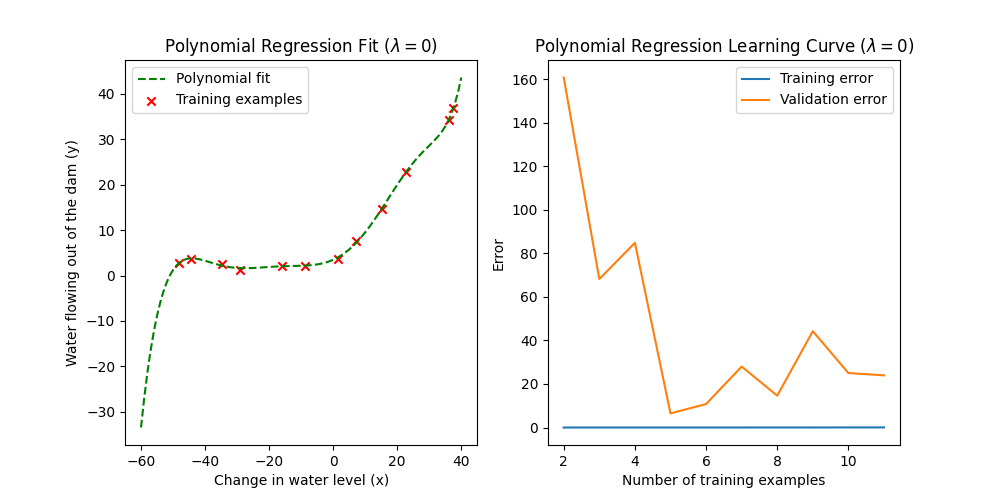

In [10]:
# The regularization parameter lmd
lmd = 0

# Using polyFeatures(..) with p=8 to map the original data to a higher dimension
p = 8
X_poly = polyFeatures(X, p) # on the training set
Xval_poly = polyFeatures(Xval, p) # on the validation set
Xtest_poly = polyFeatures(Xtest, p) # on the test set

# mean vector and standard deviation vector
mu = np.mean(X_poly, axis=0)
sigma = np.std(X_poly, axis=0)

# normalizing the training set and validation set using mu and sigma and adding an aditional first column of ones
X_poly_normalized = add_all_ones_column((X_poly - mu) / sigma)
Xval_poly_normalized = add_all_ones_column((Xval_poly - mu) / sigma)

# Training to find the optimal parameters vector theta
theta_init = np.zeros(p+1) # we p features, so we need p+1 parameters (as we have theta_0)
theta = trainLinearReg(X_poly_normalized, y, theta_init, lmd)

# Plotting the dataset and the polynomial regression curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_xlabel("Change in water level (x)")
ax1.set_ylabel("Water flowing out of the dam (y)")
ax1.set_title(r"Polynomial Regression Fit ($\lambda = {}$)".format(lmd))

ax2.set_xlabel("Number of training examples")
ax2.set_ylabel("Error")
ax2.set_title(r"Polynomial Regression Learning Curve ($\lambda = {}$)".format(lmd))

x_plot = np.linspace(-60, 40, 100)
x_plot_poly = polyFeatures(x_plot.reshape(len(x_plot), 1), p)
x_plot_poly_normalized = add_all_ones_column((x_plot_poly - mu) / sigma)
y_plot = x_plot_poly_normalized @ theta
ax1.plot(x_plot, y_plot, linestyle="--", color="green", label="Polynomial fit")
ax1.scatter(X[:, 0], y, marker="x", color="red", label = "Training examples")

# Plotting the learning curves using the training and validation sets
errs_train, errs_val = [], []
for i in range(2, len(y)):
    theta = trainLinearReg(X_poly_normalized[:i], y[:i], theta_init, lmd)
    errs_train.append( E(theta, X_poly_normalized[:i], y[:i], 0) )
    errs_val.append( E(theta, Xval_poly_normalized, yval, 0) )
    
ax2.plot(range(2, len(y)), errs_train, label="Training error")
ax2.plot(range(2, len(y)), errs_val, label="Validation error")

ax1.legend()
ax2.legend()
plt.show()

## Adjusting the regularization parameter $\lambda$
In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the $\lambda$ parameter (i.e. variable `lmd`) in previous code and try $\lambda = 1$ and $\lambda = 50$ (you could also try with other values of $\lambda$). For each of these values, the above code should generate two figures (the polynomial fit to the data and the learning curve).

For $\lambda = 1$, you should see a polynomial fit that follows the data trend well and a learning curve showing that both the validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In fact, it achieves a good trade-off between bias and variance. For $\lambda = 50$, you should see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

## Selecting $\lambda$ using the validation set
From the previous section, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization (e.g. $\lambda = 50$) does not fit the data well. A good choice of $\lambda$ (e.g., $\lambda = 1$ for this dataset) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Your task is to complete the code below. Specifically, you should use the `trainLinearReg(..)` function to train the model using different values of $\lambda$ and compute the training error and validation error. You should try $\lambda$ in the following range: `[0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]`. You should also plot a curve that shows the validation error and training error with respect to the different values of $\lambda$. You should see a plot similar to the following figure, which allows you to select which $\lambda$ parameter to use. In this figure, we can see that the best value of $\lambda$ is around $3$ (as it gives the smallest validation error).

<img src="imgs/Lab4AerrVSlambda.png" width="400px" />

*Note:* Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

<IPython.core.display.Javascript object>


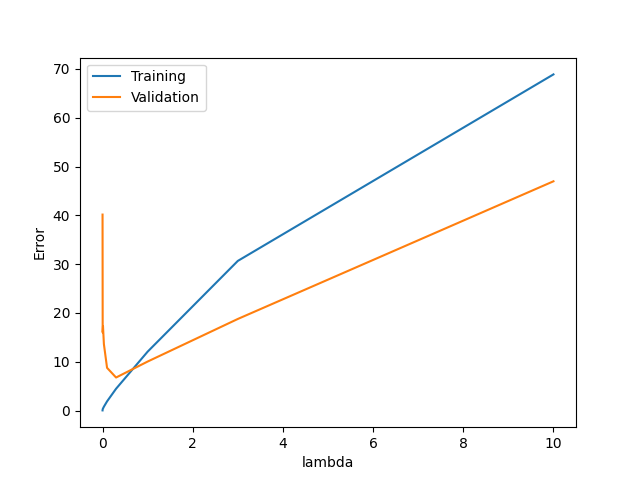

In [11]:
lmd_range = [0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
errs_train, errs_val = [], []

""" TODO:
For each value of lmd you should call trainLinearReg(..) to train a model using the training set 
X_poly_normalized, y, then compute the training error (on the training set: X_poly_normalized, y) 
and the validation error (on the validation set: Xval_poly_normalized, yval).
"""

for lmd in lmd_range:
    theta = trainLinearReg(X_poly_normalized, y, theta_init, lmd)
    errs_train.append(E(theta, X_poly_normalized, y, lmd))
    errs_val.append(E(theta, Xval_poly_normalized, yval, lmd))


""" TODO:
Plot a curve that shows the validation error and training error with respect to lambda
"""
fig, ax = plt.subplots()
# Plot of the training errors vs lambda values
ax.plot(lmd_range, errs_train, label='Training')
# Plot of the validation errors vs lambda values
ax.plot(lmd_range, errs_val, label='Validation')

ax.set_xlabel("lambda")
ax.set_ylabel("Error")
ax.legend()
fig.show()


## Computing test set error
In the previous section, you implemented code to compute the validation error for various values of the regularization parameter $\theta$. However, to get a better indication of the model's performance in the real world, it is important to evaluate the "*final*" model on a test set that was not used in any part of training (that is, it was neither used to select the regularization parameter $\lambda$, nor to learn the model parameters $\theta$).

In the code below, you should compute the test error using the best value of $\theta$ you found (using $\lambda = 3$).

In [20]:
""" TODO:
Find the best parameters vector theta by training the polynomial regression 
model using lambda = 3. Then compute the error on the test set.
Note: don't forget to normalize the test set before.
"""
Xtest_poly = polyFeatures(Xtest, 8)
Xtest_poly_normalized = add_all_ones_column((Xtest_poly - mu) / sigma)
# ...
err_test = E(theta, Xtest_poly_normalized, ytest, 0.3)
print("err_test =", err_test)

err_test = 35.378159035700634


## (OPTIONAL) Performing a 10-fold-cross-validation

This section is optional.

Combine the training and validation sets into one set `Xall`, `yall`. Note: in Python you can combine two datasets A and B (two numpy arrays) into one dataset using `AB = np.append(A, B, axis=0)`.

Implement 10-fold-cross-validation to evaluate to find the best value for the hyperparameter $\lambda$. This will be the value that gives you the best generalization error.

Finally, use this best value of $\lambda$ to train a model on the whole dataset `Xall`, `yall`, and then test this model on the test dataset `Xtest`, `ytest` and compute the test error.

In [ ]:
""" TODO
Plot the learning curves based on randomly selected examples as described above.
"""
# Combine X with Xval
# Combine y with yval
# Perform a 10-fold-cross-validation to find the best value for the hyperparameter lambda